In [ ]:
!pip install ale-py
!pip install "gymnasium"
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import numpy as np


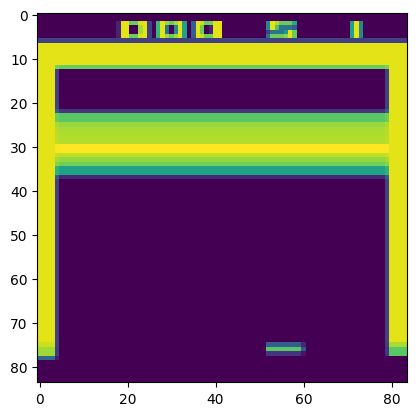

In [ ]:
env = gym.make('ALE/Breakout-v5', render_mode="rgb_array")
#Espacio de acciones:
#0: NOOP
#1: FIRE
#2: RIGHT
#3: LEFT

obs, info = env.reset()
env = AtariPreprocessing(
    env,
    noop_max=30,
    frame_skip=1,        # salta frames (reduce cómputo)
    screen_size=84,      # 84x84
    grayscale_obs=True,  # 1 canal
    scale_obs=False,     # si True normaliza a [0,1] (float)
)
env = FrameStackObservation(env, stack_size=4)  # buffer: apila 4 frames
obs, info = env.reset()
plt.imshow(obs[0])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
if os.path.exists('/content/drive/MyDrive/modelosNN/breakthrough.pth'):
  !cp '/content/drive/MyDrive/modelosNN/breakthrough.pth' './breakthrough.pth'
else:
  print('No se encontró el archivo')

Mounted at /content/drive


In [ ]:
#Red neuronal para el procesamiento de la imagen de estado del juego
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=3,stride=1,padding=1)  # -> (16, 82, 82)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # -> (32, 82, 82)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # -> (32, 82, 82)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*10*10, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
#Verificación de la red
model=ConvNet()
x=torch.tensor(obs,dtype=torch.float32).unsqueeze(0)
x=torch.rand((10,4,84,84))
x.shape, model(x).shape

cuda:0


(torch.Size([10, 4, 84, 84]), torch.Size([10, 4]))

In [ ]:
from collections import deque
import random
# ==============================
# 2. Buffer de experiencia
# ==============================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state),
                np.array(action),
                np.array(reward, dtype=np.float32),
                np.array(next_state),
                np.array(done, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)

In [ ]:
# ==============================
# 3. Agente DQN
# ==============================
import os

class DQNAgent:
    def __init__(self, gamma=0.99, lr=1e-3, buffer_size=10000, batch_size=128, tau=0.005):
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.update_every=64
        self.contador=0
        self.error=[]
        # Redes neuronal principal y objetivo
        if os.path.exists('breakthrough.pth'):
            state_dict = torch.load('breakthrough.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu')
        else:
            state_dict = None
        self.policy_net = ConvNet()
        if(state_dict):
            print('Se cargó el entrenamiento previo')
            self.policy_net.load_state_dict(state_dict)
        self.policy_net.to(device)
        self.target_net = ConvNet()
        if(state_dict):
            self.target_net.load_state_dict(state_dict)
        self.target_net.to(device)
        self.target_net.eval()

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state, epsilon=0.1): #Epsilon Greedy
        if random.random() < epsilon:
            return random.randrange(4)
        state = torch.tensor([state], dtype=torch.float32)
        with torch.no_grad():
            q_values = self.policy_net(state.to(device)).cpu()
        return int(torch.argmax(q_values).item())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self):
        self.contador-=1
        if(self.contador>0):
            return
        else:
            self.contador=self.update_every
            #print('Update')
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Q(s,a)
        q_values = self.policy_net(states.to(device)).gather(1, actions.to(device))

        # max Q'(s', a')
        with torch.no_grad():
            max_next_q = self.target_net(next_states.to(device)).max(1)[0].unsqueeze(1)
            target_q = rewards.to(device) + (1 - dones.to(device)) * self.gamma * max_next_q

        loss = nn.MSELoss()(q_values, target_q)
        self.error.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Actualización suave de la red objetivo
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
          target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

In [ ]:
# ==============================
# 4. Loop de entrenamiento
# ==============================
def train_dqn(agent, env, episodes=500, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
    rwrd=[]
    epsilon = epsilon_start
    for episode in range(episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        cnt=0
        while not done:
            cnt+=1
            action = agent.select_action(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            done=terminated or truncated
            #print(state, action, reward, next_state, done)
            agent.store_transition(state, action, reward, next_state, done)
            agent.update()

            state = next_state
            total_reward += reward
            if cnt>1000:
              done=True
        rwrd.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        print(f"\rEpisode {episode+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}", end='')

In [ ]:
obs, info=env.reset()

agent = DQNAgent()
num=1000
train_dqn(agent, env, episodes=num, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=np.power(0.01/1,1/num))

Se cargó el entrenamiento previo
Episode 2/1000, Total Reward: 3.00, Epsilon: 0.991

/tmp/ipython-input-1876966778.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float32)


Episode 1000/1000, Total Reward: 1.00, Epsilon: 0.010

In [ ]:
!pip install imageio[ffmpeg]
st, info=env.reset()
print(st.shape)
import imageio
frames = []
flag=True
contador=0
while(flag and contador<5000):
  st=torch.tensor(st).float().unsqueeze(0)
  out=agent.policy_net(st.to(device)).detach().cpu().numpy()[0]
  action=np.argmax(out)
  observation, reward, terminated, truncated, info = env.step(action)
  fr=env.render()
  frames.append(fr)
  if terminated or truncated:
    flag=False
  st=observation
  contador+=1

output_path = "animacion.mp4"
imageio.mimsave(output_path, frames, fps=20)

(4, 84, 84)


In [ ]:
torch.save(agent.policy_net.state_dict(), 'breakthrough.pth')
!cp './breakthrough.pth' '/content/drive/MyDrive/modelosNN/breakthrough.pth'